In [1]:
import numpy as np
import math
import csv
import matplotlib as mpl
import os
import scipy.constants as pc
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import writers

%matplotlib notebook

In [2]:
def normalize(x):
    max = 0.0
    for i in range(len(x)):
        if abs(x[i]) > max:
            max = abs(x[i])
    for i in range(len(x)):
        x[i] /= max
    return x

In [3]:
def lorentzian(Vib_Freq_axis, peak_pos, CID3, fwhm):
    ROA = [0]*len(Vib_Freq_axis)
    Vib_Freq_axis_cm1 = np.zeros(len(Vib_Freq_axis))
    for i in range(0,len(Vib_Freq_axis)):
        for j in range(0,len(peak_pos)):
            ROA[i] += CID3[j]/(1+(2*(Vib_Freq_axis[i]-peak_pos[j])/fwhm)**2)
        Vib_Freq_axis_cm1[i] = Vib_Freq_axis[i]*8065.54429
    return normalize(ROA), Vib_Freq_axis_cm1

In [4]:
def lorentzian_with_snap(max_freq, min_freq, Vib_Freq, fwhm, CID3, peak_pos, snapshots, num_points):
    delta = float((max_freq-min_freq)/num_points)
    Vib_Freq_axis = np.arange(min_freq,max_freq,delta)
    Vib_Freq_axis_cm1 = np.zeros(len(Vib_Freq_axis))
    ROA = [0]*len(Vib_Freq_axis)
    Vib_Freq_axis_cm1 = np.zeros(len(Vib_Freq_axis))
    for i in range(0,len(Vib_Freq_axis)):
        for j in range(0,len(peak_pos)):
            ROA[i] += CID3[j]/(1+(2*(Vib_Freq_axis[i]-peak_pos[j])/fwhm)**2)
        Vib_Freq_axis_cm1[i] = Vib_Freq_axis[i]*8065.54429
    return normalize(ROA), Vib_Freq_axis_cm1

In [5]:
#Read data from files

with open("Sorted.txt","r") as f:
    cmpd = []
    GFE = []
    Vib_Freq = []
    CID3 = []
    content = f.readlines()
    for line in content:
        splitted_line = line.split()
        cmpd.append(int(splitted_line[0]))
        GFE.append(float(splitted_line[1]))
        Vib_Freq.append(float(splitted_line[2]))
        CID3.append(float(splitted_line[3]))
        
with open("Combined_Free_Energy.txt","r") as f:
    cmpd2 = []
    GFE2 = []
    content = f.readlines()
    for line in content:
        splitted_line = line.split()
        cmpd2.append(int(splitted_line[0]))
        GFE2.append(float(splitted_line[1]))
        
peak_pos = []
        
peaks, _ = find_peaks(CID3)
for i in range(len(peaks)):
    temp = peaks[i]
    peak_pos.append(Vib_Freq[temp])

num_points = 2000
fwhm = 0.002
#max_freq = max(Vib_Freq)
#min_freq = min(Vib_Freq)
max_freq = 0.49593677
min_freq = 0

delta = float((max_freq-min_freq)/num_points)
Vib_Freq_axis = np.arange(min_freq,max_freq,delta)
ROA_conv, Vib_Freq_axis_cm1_conv = lorentzian(Vib_Freq_axis, peak_pos, CID3, fwhm)

In [6]:
tot_snapshots = len(cmpd2)
print("Total number of snapshots : ", tot_snapshots)
step_size = 5
steps = tot_snapshots/step_size

snaps = []
freq = []
spec = []

X = []
Y = []

cmpd3 = []
Vib_Freq3 = []
CID33 = []

max_freq = 0.49593677
min_freq = 0

print("Calculating dynamic spectrum with the number of snapshots : ")

ctr = np.zeros(100).tolist()
cmpd_rs = []
Vib_Freq_rs = []
CID3_rs = []
with open("Sorted_rs.txt","r") as f:
    content = f.readlines()
    for line in content:
        splitted_line = line.split()
        cmpd_rs.append(int(splitted_line[0]))
        Vib_Freq_rs.append(float(splitted_line[2]))
        CID3_rs.append(float(splitted_line[3]))
        

for j in range(0,100):
    ctr[j] = cmpd.count(j+1)
beg = 0
for snap in range(step_size, tot_snapshots+1, step_size):
    print("Collecting data for snapshot : ", snap)
    end = sum(ctr[0:snap])
    snaps.append(snap)
    cmpd3.extend(cmpd_rs[beg:end])
    Vib_Freq3.extend(Vib_Freq_rs[beg:end])
    CID33.extend(CID3_rs[beg:end])
    beg = end
    
    combined = list(zip(Vib_Freq3, CID33))
    combined.sort()
    Vib_Freq3_new, CID33_new = zip(*combined)
    
    peak_pos3 = []
    peaks3, _ = find_peaks(CID33_new)
    for i in range(len(peaks3)):
        temp3 = peaks3[i]
        peak_pos3.append(Vib_Freq3_new[temp3])
        
    spec,freq = lorentzian_with_snap(max_freq, min_freq, Vib_Freq3_new, fwhm, CID33_new, peak_pos3, snap, num_points )
    Y.append(spec)
    X.append(freq)

Total number of snapshots :  100
Calculating dynamic spectrum with the number of snapshots : 


<IPython.core.display.Javascript object>


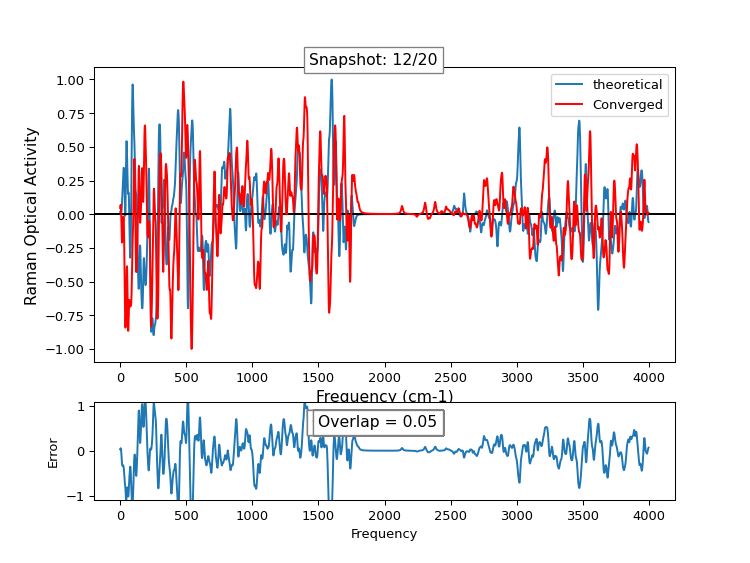

In [7]:
# Create the figure and axes
plt.rcParams["figure.figsize"] = [8,6]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
line1, = ax1.plot(X[0], Y[0], label="theoretical")
freq_exp = np.array(Vib_Freq_axis_cm1_conv)
spec_exp = np.array(ROA_conv)
line2, = ax2.plot(freq_exp, Y[0], label="Error")
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Error')

ax1.set_xlabel('Frequency (cm-1)', fontsize=12)
ax1.set_ylabel('Raman Optical Activity', fontsize=12)
ax1.axhline(y = 0, color = 'black')
snapshot = ax1.text(2400, 1.2, '', ha='right', va='top', fontsize=12,bbox=dict(facecolor='white', edgecolor='gray'))

# Define the number of frames to be the length of Y
num_frames = len(Y)
ax1.plot(Vib_Freq_axis_cm1_conv, ROA_conv, color="red", label="Converged")
ax1.legend()



overlap_list = []
# Define the animation function to update the y-data of line0 and snapshot
def animate(i):
    line1.set_ydata(Y[i])
    line1.set_xdata(X[i])

    freq_theory = np.array(X[i])
    spec_theory = np.array(Y[i])
    error = spec_exp - spec_theory
    # Calculate the overlap
    overlap = np.trapz(spec_exp*spec_theory, freq_exp)
    deno1 = np.trapz(spec_exp*spec_exp, freq_exp)
    deno2 = np.trapz(spec_theory*spec_theory, freq_exp)
    deno = np.sqrt(deno1*deno2)
    overlap /= deno
    
    overlap_list.append(overlap)
    
    snapshot.set_text('Snapshot: ' + str(i+1) + '/' + str(num_frames))
    # Plot the error spectrum on the lower axes
    line2.set_ydata(error)
    line2.set_xdata(freq_exp)
    # Plot the overlap as a text box
    ax2.text(2400, 0.8, 'Overlap = %.2f' % overlap, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray'))
    area = np.trapz(error, x=freq_exp)

    # Add the shaded area to the error plot
    #ax2.fill_between(freq_exp, error, alpha=0.2, color='blue')
    
    #ax2.set_xlim(2200,3000)
    #ax2.legend()
    return line1,line2,snapshot
    

# Plotting dynamic spectrum
ani = anim.FuncAnimation(
    fig, animate, frames=num_frames, interval=1000)

plt.show()

<IPython.core.display.Javascript object>


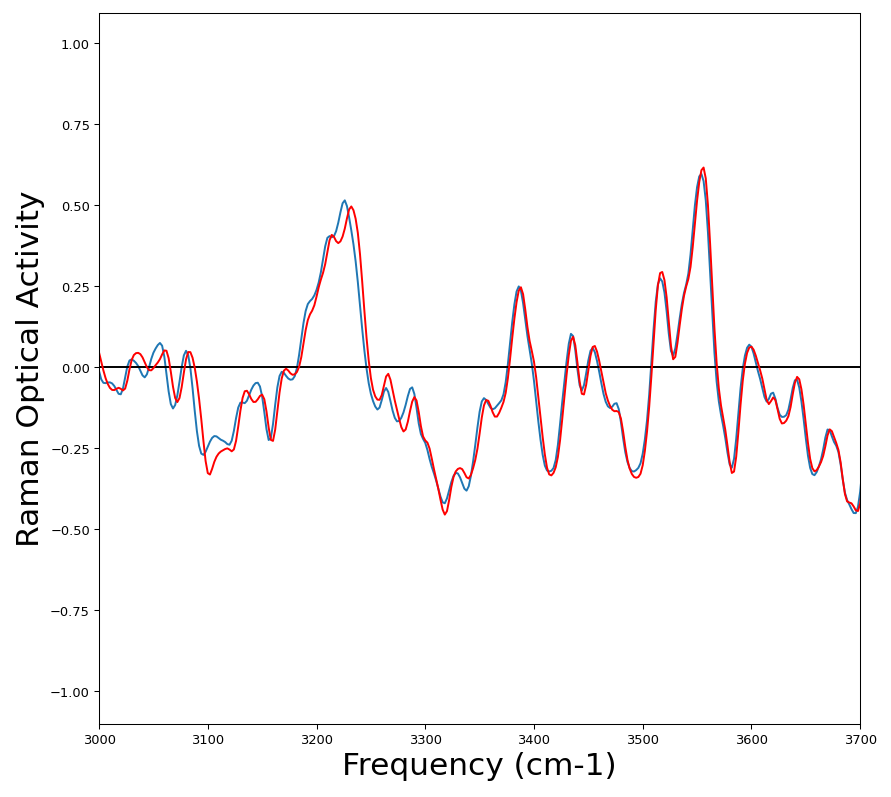

In [8]:
fig = plt.figure(figsize=(9.5, 8.5))
axs = fig.add_subplot(111)
line0, = axs.plot(X[0], normalize(Y[0]),label="ROA")

axs.set_xlim(3000,3700)
axs.set_xlabel('Frequency (cm-1)', fontsize=24)
axs.set_ylabel('Raman Optical Activity', fontsize=24)
axs.axhline(y = 0, color = 'black')
snapshot = axs.text(2800, 1, '', ha='right', va='top', fontsize=24)

# Adding converged data to the plot.
axs.plot(Vib_Freq_axis_cm1_conv, ROA_conv, color="red", label="Converged")

# Defining animation function to add data for each snapshot.
def animate(i):
    line0.set_xdata(X[i])
    line0.set_ydata(Y[i])
    snapshot.set_text('Snapshot: ' + str(int(snaps[i])))
    return line0

# Plotting dynamic spectrum.
ani = anim.FuncAnimation(
    fig, animate, interval=600, frames=20, repeat_delay=800, blit=True, cache_frame_data=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


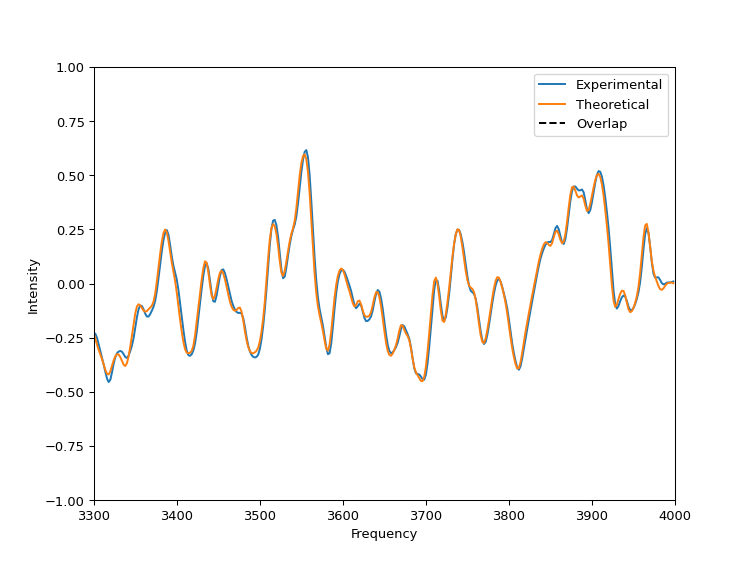

In [11]:
freq_exp = np.array(Vib_Freq_axis_cm1_conv)
spec_exp = np.array(ROA_conv)
freq_theory = np.array(X[19])
spec_theory = np.array(Y[19])

# Calculate the overlap
overlap = np.trapz(spec_exp*spec_theory, freq_exp)

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the experimental and theoretical spectra
ax.plot(freq_exp, spec_exp, label='Experimental')
ax.plot(freq_theory, spec_theory, label='Theoretical')

# Plot the overlap as a vertical line
ax.axhline(y=overlap, color='k', linestyle='--', label='Overlap')

# Set the x and y limits and labels
ax.set_ylim(-1,1)
ax.set_xlim(3300,4000)
ax.set_xlabel('Frequency')
ax.set_ylabel('Intensity')
ax.legend()

# Show the plot
plt.show()